## Pruning LeNet CNN on CIFAR-10

This Notebook gives a demo on how to prune the filters on a CNN on CIFAR-10.

**DEV:** _prune multiple layers._

### Settings

In [1]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import json
from vis_utils import *
from model_def import *
from model_train import *


# specify experiment settings
expName = 'cifar-lenet-v1_w1-1000'   #change conv1 dim
w1 = 1000 # change conv1 dim
w2 = 50

batchSize = 100
useGpu = True
numEpochs = 30
learningRate = 0.01
gamma = 0.1  # learning rate decay
lr_decay_step = 10 # decay lr every "x" epochs
momentum = 0.9
weight_decay = 5e-3

# -----------------------------------------------------------------------------


# experiment folder
expDir = os.path.join('./data', expName)

# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data(batchSize)

Files already downloaded and verified
Files already downloaded and verified


## Reduce Duplicate Filters

In [2]:
# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
print net

NetWide (
  (conv1): Conv2d(3, 1000, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(1000, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (1250 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


In [3]:
net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)

Original network data loss: 0.6741


In [4]:
# Settings
%matplotlib inline
from net_reduce import *

SIMIL_THRESH = 0.8
LAYER_CURR = 'conv2'
LAYER_NEXT = 'fc1'

### Network reduction

Reducing a network by eliminating near-duplicate filters consists of the following steps, after having formed groups of similar filters:

1. down-scale the filters of the current layer to have unit norm, and correspondingly up-scale the next layer filters.
2. collapse filter groups

In [5]:
# Check the network accuracy pre-reduction
net.eval()
net.cuda()
orig_accu = accuracy_on_dataset(net, testloader, True)
print 'Network accuracy: %.2f%%' % orig_accu

net.cuda()
new_data_loss = get_dataset_loss(net, testloader)
orig_data_loss = np.asarray(orig_data_loss)
print 'Orig mean data loss: %f' % np.mean(orig_data_loss)

Network accuracy: 77.00%
Orig mean data loss: 0.674083


### Reduce similar filters


##### Check the norms after scaling

In [6]:
scale_net_params(net, LAYER_CURR, LAYER_NEXT)

In [7]:
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
layer_curr_biases = get_param(net, LAYER_CURR+'.bias')
layer_next_weights = get_param(net, LAYER_NEXT+'.weight')

In [8]:
layer_curr_weights


( 0 , 0 ,.,.) = 
  2.6936e-02  2.2782e-02  2.0990e-02  1.2997e-02  2.4354e-02
  5.0329e-03  1.6226e-02  2.4734e-02  3.2390e-02  4.2279e-02
  1.8199e-02  2.9659e-02  3.8192e-02  2.8171e-02  4.2749e-02
  4.1076e-02  3.6672e-02  2.6345e-02  1.2618e-02  1.3468e-02
  4.6971e-02  2.7316e-02  1.2959e-02 -1.4426e-03  4.1625e-03

( 0 , 1 ,.,.) = 
 -4.9942e-03  1.6902e-03  7.2809e-03  7.1805e-03  1.0450e-02
 -4.4239e-03  3.0246e-03  1.0006e-02  1.4668e-02  2.3109e-02
 -1.0216e-02 -8.8354e-04  7.8284e-03  1.5457e-02  2.7404e-02
 -1.5124e-02 -4.0863e-03  4.4970e-03  1.1890e-02  2.0489e-02
 -1.2782e-02 -4.8214e-03  2.5899e-04  2.9589e-03  7.6495e-03

( 0 , 2 ,.,.) = 
 -1.8907e-02 -1.0928e-02 -1.0688e-02 -8.2426e-03 -1.3649e-04
 -5.5260e-03  4.2941e-03  9.5342e-04 -1.9223e-03  8.2369e-03
  2.5683e-03  1.2569e-02  8.0482e-03  3.4455e-03  1.1722e-02
  9.8042e-03  1.4988e-02  1.0812e-02  7.0169e-03  1.7240e-02
  1.6115e-02  2.0022e-02  1.6212e-02  1.6192e-02  2.3957e-02
    ... 

( 0 ,497,.,.) = 
 -4.

In [8]:
torch.norm(layer_curr_weights[10],p=2)

1.0000000028970362

##### Check the reduction operation

In [9]:
# 1. unit-normalizes current layer filters
# 2. finds similar groups of filters and merges them

# code: net_reduce.py
#   return args are for diagnostics and n_comps needed for norm-baseline
n_comps, cc_list, similMat, adj_mat = \
reduce_similar_filters(net, LAYER_CURR, LAYER_NEXT, SIMIL_THRESH)

50


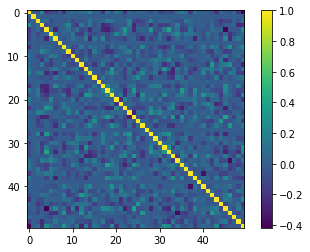

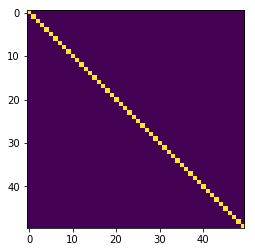

In [10]:
print n_comps
f = plt.figure()
plt.imshow(similMat)
plt.colorbar()
f = plt.figure()
plt.imshow(adj_mat)

In [11]:
# Sanity check: verify that the network's param sizes have changed
print net.fc1.weight.size()
print net.fc1.bias.size()
print net.conv2.weight.size()

torch.Size([120, 1250])
torch.Size([120])
torch.Size([50, 1000, 5, 5])


In [12]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu

# res = {'orig_accu': orig_accu, 'reduced_accu': abl_accu, \
#        'num_filters': n_comps}
# with open(os.path.join(expDir,'reduce_dup_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
#     json.dump(res, res_file, indent=4, separators=(',', ': '), \
#                                           sort_keys=True)

Reduced network accuracy: 77.00 %


In [10]:
# save reduced network 
torch.save(net.state_dict(), os.path.join(expDir,'net-reduced-dup-%.2f.dat' % SIMIL_THRESH))

([], <a list of 0 Text yticklabel objects>)

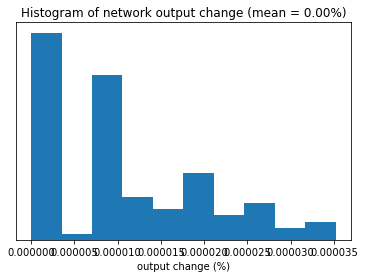

In [15]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
# f.savefig(os.path.join(expDir,'loss-delta-reduced-dup-%.2f.png' % SIMIL_THRESH))

### Baseline: low L1 norm

In [13]:
# baseline: keep same number of filters as the duplicate method
NUM_KEEP = n_comps 

# re-load the original network
net = NetWide(conv1_num_filter=w1, conv2_num_filter=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

net.cuda()
orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)


Original network data loss: 0.6741


In [14]:
# code: net_reduce.py
reduce_low_norm_filters(net, LAYER_CURR, LAYER_NEXT, NUM_KEEP)

In [15]:
# Evaluate baseline network's accuracy
net.cuda()
net.eval()
baseline_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % baseline_accu

# res = {'orig_accu': orig_accu, 'reduced_accu': baseline_accu, \
#         'num_filters': n_comps}
# with open(os.path.join(expDir,'reduce_norm_acc_%.2f.json' % SIMIL_THRESH), 'w') as res_file :
#     json.dump(res, res_file, indent=4, separators=(',', ': '), \
#                                           sort_keys=True)

Reduced network accuracy: 77.00 %


([], <a list of 0 Text yticklabel objects>)

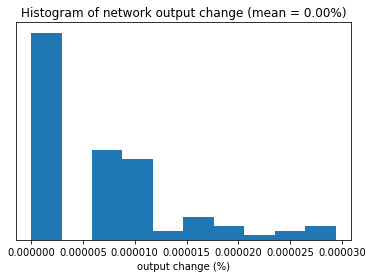

In [16]:
# Histogram of network output difference
net.cuda()
net.eval()
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

f = plt.figure()
plt.hist(net_diff_percent, normed=True);
ax = plt.gca()
plt.xlabel('output change (%)')
plt.title('Histogram of network output change (mean = %.2f%%)' % np.mean(net_diff_percent))
plt.yticks([])
# f.savefig(os.path.join(expDir,'loss-delta-reduced-norm-%.2f.png' % SIMIL_THRESH))